In [1]:
import glob
import re
import json 
import itertools
import functools

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rc('font', family='Arial', size=12)

In [2]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str), sep='-'), sep=':')

def read_matrix_file(f):
    temp = pd.read_csv(f, compression='gzip', comment='@', sep='\t', header=None)
    # Generate a UCSC style description of the peak coordinates
    ucsc_idx = (temp.iloc[:, 0].str.cat(
                    temp.iloc[:, 1].astype(str).str.cat(
                        temp.iloc[:, 2].astype(str),
                    sep= '-'), 
                sep=':'))
    # Drop the first 6 columns, which here act as a descriptor
    return temp.set_index(ucsc_idx).drop(range(6), axis=1).fillna(0)

In [31]:
tss_data = {}
tss_data['gc'] = read_matrix_file('../../genome_correlations/skew/skew_over_gl3_peaks_including_strand_unbaised.temp')
tss_data['at'] = read_matrix_file('../../genome_correlations/skew/at_skew_over_gl3_peaks_including_strand_unbaised.temp')

In [34]:
validated_sites = pd.read_csv('../../peak_calls/combined_bam_peaks/gl3_broad_annotated_nofilter_strand_bias.bed',
                         sep = '\t', names = ('chr', 'start', 'end', 'name','value', 'strand')
                        )

In [35]:
validated_sites.name = ucsc_index(validated_sites)

In [36]:
filtered_peaks = {k: v[v.index.isin(set(validated_sites.name))].copy() for k,v in tss_data.items()}

In [37]:
for name, mat in filtered_peaks.items():
    minus_peaks = set(validated_sites.loc[validated_sites.strand == '-', 'name'])
    mat.loc[mat.index.isin(minus_peaks), :] = -mat.loc[mat.index.isin(minus_peaks), :].as_matrix()[:, ::-1]

In [38]:
filtered_peaks['gc'].head()

,6,7,8,9,10,11,12,13,14,15,...,176,177,178,179,180,181,182,183,184,185
0,,,,,,,,,,,,,,,,,,,,,
chr1:100012840-100014213,0.216752,0.216752,0.216752,0.216752,0.216752,0.216752,0.222516,0.222516,0.222516,0.222516,...,0.143697,0.143697,0.143697,0.143697,0.143697,0.143697,0.143697,0.143697,0.118347,0.059196
chr1:100019476-100022850,0.148240,0.148240,0.142102,0.138010,0.138010,0.138010,0.138010,0.138010,0.138010,0.138010,...,0.039548,0.039548,0.039548,0.039548,0.039548,-0.115540,-0.115540,-0.115540,-0.115540,-0.115540
chr1:100033590-100040859,0.026094,0.116304,0.116304,0.116304,0.116304,0.116304,0.116304,0.116304,0.116304,0.116304,...,0.176932,0.176932,0.176932,0.176932,0.050831,0.036819,0.036819,0.036819,0.036819,0.036819
chr1:100061867-100090379,-0.055578,-0.055578,-0.055578,0.046123,0.089710,0.089710,0.089710,0.089710,0.089710,0.089710,...,0.092013,0.092013,-0.000568,-0.010855,-0.010855,-0.010855,-0.010855,-0.010855,-0.010855,-0.010855
chr1:100124816-100126950,-0.103462,-0.103462,-0.103462,-0.103462,-0.103462,-0.103462,-0.103462,-0.103462,-0.073681,-0.053828,...,0.279811,0.279811,0.279811,0.279811,0.279811,0.150889,0.150889,0.150889,0.150889,0.150889


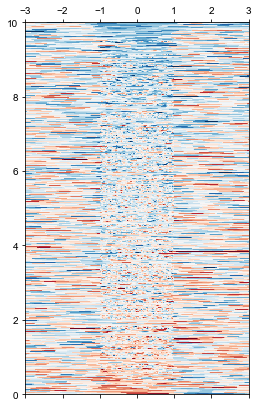

In [39]:
plt.matshow(filtered_peaks['gc'].iloc[np.argsort(filtered_peaks['gc'].iloc[:, 60:120].mean(axis=1))[::-1], :],
            extent = [-3, 3, 0, 10], cmap='RdBu', vmin=-0.5, vmax=0.5)

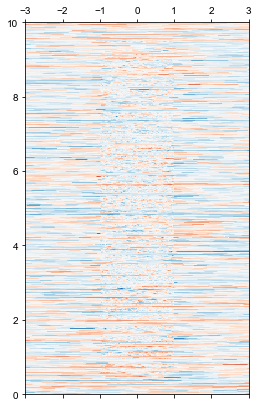

In [40]:
plt.matshow(-filtered_peaks['at'].iloc[np.argsort(filtered_peaks['gc'].iloc[:, 60:120].mean(axis=1))[::-1], :],
            extent = [-3, 3, 0, 10], cmap = 'RdBu', vmin=-1, vmax=1)

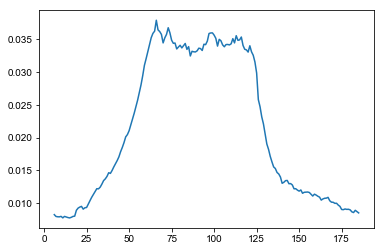

In [41]:
filtered_peaks['gc'].mean(axis=0).plot()

In [42]:
def bootstrap_samples(mat, n_samples, agg_func = np.mean, verbose=False, sample_name = ''):
    agg_func = functools.partial(agg_func, axis=0)
    boot_samples = np.empty((n_samples, mat.shape[1]), dtype=np.float32)
    for i in range(n_samples):
        if verbose and not i % (n_samples // 25):
            print(sample_name, (i / n_samples) * 100)
        boot_samples[i, :] = agg_func(mat[np.random.choice(len(mat), len(mat), replace=True), :])
    return boot_samples

In [43]:
def mean_95_ci(ax, mat, x = None, color='blue'):
    if x is None:
        x = np.arange(0, mat.shape[1], 1)
    ax.plot(x, mat.mean(axis=0), color=color)
    ax.fill_between(x, 
                    np.percentile(mat, 2.5, axis=0), 
                    np.percentile(mat, 97.5, axis=0),
                    alpha = 0.5, color=color)

In [44]:
gc_skew_boot = bootstrap_samples(filtered_peaks['gc'].as_matrix(), 5000, verbose=True)

 0.0
 4.0
 8.0
 12.0
 16.0
 20.0
 24.0
 28.000000000000004
 32.0
 36.0
 40.0
 44.0
 48.0
 52.0
 56.00000000000001
 60.0
 64.0
 68.0
 72.0
 76.0
 80.0
 84.0
 88.0
 92.0
 96.0


In [45]:
at_skew_boot = bootstrap_samples(filtered_peaks['at'].as_matrix(), 5000, verbose=True)

 0.0
 4.0
 8.0
 12.0
 16.0
 20.0
 24.0
 28.000000000000004
 32.0
 36.0
 40.0
 44.0
 48.0
 52.0
 56.00000000000001
 60.0
 64.0
 68.0
 72.0
 76.0
 80.0
 84.0
 88.0
 92.0
 96.0


In [46]:
down_color = '#6669cf'
up_color = '#fc5566'

In [47]:
at_skew_boot

array([[-0.03447182, -0.03415109, -0.03380564, ..., -0.02855275,
        -0.02852405, -0.0281274 ],
       [-0.03428739, -0.03384427, -0.03324597, ..., -0.02800068,
        -0.02806336, -0.02779718],
       [-0.03380954, -0.03342042, -0.03259047, ..., -0.02923647,
        -0.0292241 , -0.0283641 ],
       ...,
       [-0.03202876, -0.03117669, -0.0303592 , ..., -0.02625329,
        -0.02636981, -0.02613143],
       [-0.03394986, -0.03386299, -0.03333142, ..., -0.02628772,
        -0.02637707, -0.02588003],
       [-0.03294576, -0.03258236, -0.03199374, ..., -0.02653666,
        -0.02651465, -0.02632968]], dtype=float32)

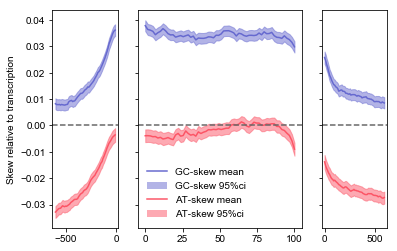

In [48]:
fig, ax = plt.subplots(ncols = 3,sharey=True, gridspec_kw={'width_ratios': [0.8,2, 0.8]})

down_color = '#6669cf'
up_color = '#fc5566'


mean_95_ci(ax[0], gc_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = down_color)
mean_95_ci(ax[0], at_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = up_color)

mean_95_ci(ax[1], gc_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = down_color)
mean_95_ci(ax[1], at_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = up_color)

mean_95_ci(ax[2], gc_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = down_color)
mean_95_ci(ax[2], at_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = up_color)

for a in ax:
    a.axhline(y=0, linestyle='--', color = '#666666')
ax[0].set_ylabel('Skew relative to transcription')

handles = [
    mpl.lines.Line2D([0], [0], color=down_color),
    mpl.patches.Patch(facecolor=down_color, alpha=0.5),
    mpl.lines.Line2D([0], [0], color=up_color),
    mpl.patches.Patch(facecolor=up_color, alpha=0.5),
]

labels = ['GC-skew mean', 'GC-skew 95%ci', 'AT-skew mean', 'AT-skew 95%ci']

ax[1].legend(labels=labels, handles = handles,frameon=False)

In [19]:
?gs.update

Object `gs.update` not found.


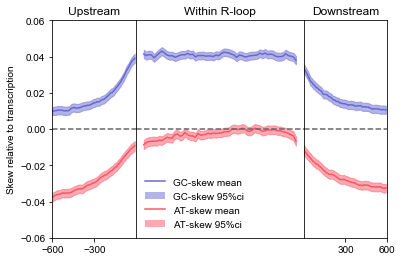

In [20]:
plt.figure(figsize=(6,4))
gs = mpl.gridspec.GridSpec(1,3, width_ratios=[1,2, 1])
ax = [plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])]
gs.update(wspace=0)
down_color = '#6669cf'
up_color = '#fc5566'


mean_95_ci(ax[0], gc_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = down_color)
mean_95_ci(ax[0], at_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = up_color)

mean_95_ci(ax[1], gc_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = down_color)
mean_95_ci(ax[1], at_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = up_color)

mean_95_ci(ax[2], gc_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = down_color)
mean_95_ci(ax[2], at_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = up_color)

for i, a in enumerate(ax):
    a.axhline(y=0, linestyle='--', color = '#666666')
    a.set_ylim(-0.06, 0.06)
    if i > 0:
        a.yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[0].set_ylabel('Skew relative to transcription')
ax[0].set_xlim(-600, 0)
ax[2].set_xlim(0, 600)

ax[0].xaxis.set_ticks([-600, -300])
ax[2].xaxis.set_ticks([300, 600])

ax[0].set_title('Upstream')
ax[1].set_title('Within R-loop')
ax[2].set_title('Downstream')

handles = [
    mpl.lines.Line2D([0], [0], color=down_color),
    mpl.patches.Patch(facecolor=down_color, alpha=0.5),
    mpl.lines.Line2D([0], [0], color=up_color),
    mpl.patches.Patch(facecolor=up_color, alpha=0.5),
]

labels = ['GC-skew mean', 'GC-skew 95%ci', 'AT-skew mean', 'AT-skew 95%ci']

ax[1].legend(labels=labels, handles = handles,frameon=False)

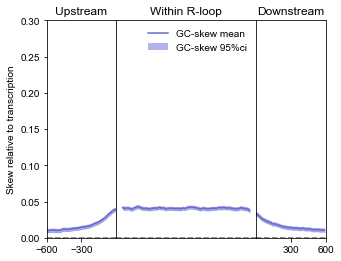

In [21]:
fig = plt.figure(figsize=(5,4))
gs = mpl.gridspec.GridSpec(1,3, width_ratios=[1,2, 1])
ax = [plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])]
gs.update(wspace=0)
down_color = '#6669cf'
up_color = '#fc5566'


mean_95_ci(ax[0], gc_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = down_color)

mean_95_ci(ax[1], gc_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = down_color)

mean_95_ci(ax[2], gc_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = down_color)

for i, a in enumerate(ax):
    a.axhline(y=0, linestyle='--', color = '#666666')
    a.set_ylim(0, 0.30)
    if i > 0:
        a.yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[0].set_ylabel('Skew relative to transcription')
ax[0].set_xlim(-600, 0)
ax[2].set_xlim(0, 600)

ax[0].xaxis.set_ticks([-600, -300])
ax[2].xaxis.set_ticks([300, 600])

ax[0].set_title('Upstream')
ax[1].set_title('Within R-loop')
ax[2].set_title('Downstream')

handles = [
    mpl.lines.Line2D([0], [0], color=down_color),
    mpl.patches.Patch(facecolor=down_color, alpha=0.5),
]

labels = ['GC-skew mean', 'GC-skew 95%ci']

ax[1].legend(labels=labels, handles = handles,frameon=False)
fig.savefig('GC_around_DRIP_seq_peaks.svg')

In [22]:
?a.legend

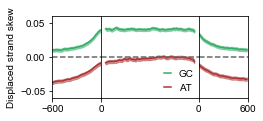

In [26]:
plt.figure(figsize=(3.5,1.5))
gs = mpl.gridspec.GridSpec(1,3, width_ratios=[1,2, 1])
ax = [plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])]
gs.update(wspace=0)
down_color = '#33ac66'
up_color = '#ac3333'


mean_95_ci(ax[0], gc_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = down_color)
mean_95_ci(ax[0], at_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = up_color)

mean_95_ci(ax[1], gc_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = down_color)
mean_95_ci(ax[1], at_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = up_color)

mean_95_ci(ax[2], gc_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = down_color)
mean_95_ci(ax[2], at_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = up_color)

for i, a in enumerate(ax):
    a.axhline(y=0, linestyle='--', color = '#666666')
    a.set_ylim(-0.06, 0.06)
    if i > 0:
        a.yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[0].set_ylabel('Displaced strand skew')
ax[0].set_xlim(-600, 0)
ax[2].set_xlim(0, 600)

ax[0].xaxis.set_ticks([-600, -0])
ax[2].xaxis.set_ticks([0, 600])

handles = [
    mpl.lines.Line2D([0], [0], color=down_color),
    mpl.lines.Line2D([0], [0], color=up_color),
]

labels = ['GC', 'AT']

ax[1].legend(labels=labels, handles = handles,frameon=False, loc = 'lower right',handlelength=0.7, borderpad=0)

fig.tight_layout()
plt.savefig('GC_skew_around_R-loops.png', dpi=300)
plt.savefig('GC_skew_around_R-loops.svg')

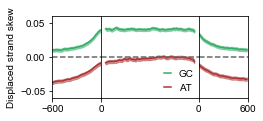

In [26]:
plt.figure(figsize=(3.5,1.5))
gs = mpl.gridspec.GridSpec(1,3, width_ratios=[1,2, 1])
ax = [plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])]
gs.update(wspace=0)
down_color = '#33ac66'
up_color = '#ac3333'


mean_95_ci(ax[0], gc_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = down_color)
mean_95_ci(ax[0], at_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = up_color)

mean_95_ci(ax[1], gc_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = down_color)
mean_95_ci(ax[1], at_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = up_color)

mean_95_ci(ax[2], gc_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = down_color)
mean_95_ci(ax[2], at_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = up_color)

for i, a in enumerate(ax):
    a.axhline(y=0, linestyle='--', color = '#666666')
    a.set_ylim(-0.06, 0.06)
    if i > 0:
        a.yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[0].set_ylabel('Displaced strand skew')
ax[0].set_xlim(-600, 0)
ax[2].set_xlim(0, 600)

ax[0].xaxis.set_ticks([-600, -0])
ax[2].xaxis.set_ticks([0, 600])

handles = [
    mpl.lines.Line2D([0], [0], color=down_color),
    mpl.lines.Line2D([0], [0], color=up_color),
]

labels = ['GC', 'AT']

ax[1].legend(labels=labels, handles = handles,frameon=False, loc = 'lower right',handlelength=0.7, borderpad=0)

fig.tight_layout()
plt.savefig('GC_skew_around_R-loops.png', dpi=300)
plt.savefig('GC_skew_around_R-loops.svg')

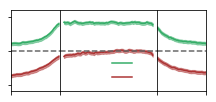

In [30]:
plt.figure(figsize=(3.5,1.5))
gs = mpl.gridspec.GridSpec(1,3, width_ratios=[1,2, 1])
ax = [plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])]
gs.update(wspace=0)
down_color = '#33ac66'
up_color = '#ac3333'


mean_95_ci(ax[0], gc_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = down_color)
mean_95_ci(ax[0], at_skew_boot[:, :60], x = np.arange(-600, 0, 10), color = up_color)

mean_95_ci(ax[1], gc_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = down_color)
mean_95_ci(ax[1], at_skew_boot[:, 60:120], x = np.linspace(0, 100, 60), color = up_color)

mean_95_ci(ax[2], gc_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = down_color)
mean_95_ci(ax[2], at_skew_boot[:, 120:], x = np.arange(0, 600, 10), color = up_color)

for i, a in enumerate(ax):
    a.axhline(y=0, linestyle='--', color = '#666666')
    a.set_ylim(-0.06, 0.06)
    if i > 0:
        a.yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[0].set_ylabel('Displaced strand skew')
ax[0].set_xlim(-600, 0)
ax[2].set_xlim(0, 600)

ax[0].xaxis.set_ticks([-600, -0])
ax[2].xaxis.set_ticks([0, 600])

handles = [
    mpl.lines.Line2D([0], [0], color=down_color),
    mpl.lines.Line2D([0], [0], color=up_color),
]

for i, a in enumerate(ax):
    a.set_yticklabels('')
    a.set_xticklabels('')
    a.set_ylabel('')

labels = ['  ', '   ']

ax[1].legend(labels=labels, handles = handles,frameon=False, loc = 'lower right')

fig.tight_layout()
plt.savefig('GC_skew_around_R-loops.png', dpi=300)
plt.savefig('GC_skew_around_R-loops.svg')

(-0.06, 0.06)

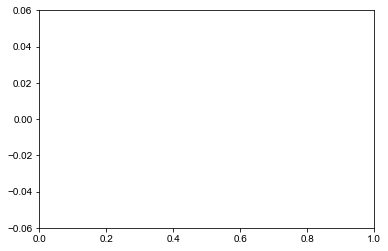

In [24]:
fig, ax = plt.subplots()

ax.set_ylim(-0.06, 0.06)

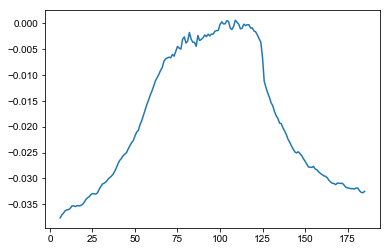

In [25]:
filtered_peaks['at'].mean(axis=0).plot()